In [1]:
from config import *
from utils import *

import os
import csv
import regex
import numpy as np

# Suppress pandas future warning, which messes tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

from tqdm.notebook import tqdm
from Bio import SeqIO

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# lib-SA Library
Load our designed lib-SA library. There are 1,927 intron-exon sequences, and 4,000 gRNAs that target them.

In [2]:
exp_design.head()

,Azimuth score,Cas type,Cutsite within sequence,"Designed 61-bp target site (37i-24e, AG)","Designed 61-bp target site (37i-24e, CT reverse-complement)","Designed gRNA (NGG orientation, 19 and 20)",Has AG,MaxEntScan AG disruption frequency in MH dels and insertions genomic_context,MaxEntScan AG disruption frequency in MH dels and insertions library_context,Ontarget score,...,inDelphi Precision library_context,inDelphi expected indel length genomic_context,inDelphi expected indel length library_context,inDelphi highest outcome frequency genomic_context,inDelphi highest outcome frequency library_context,inDelphi logphi genomic_context,inDelphi logphi library_context,strand,total_vars,Designed gRNA (NGG orientation)
Identifier number,,,,,,,,,,,,,,,,,,,,,
2,0.685572,SpCas9,68,GGAAATGCCCTGCCTAAGCTTTGGGTGCCCCCTGCAGTCCTGACCT...,GCAGGATGATGATCCAGGTCAGGACTGCAGGGGGCACCCAAAGCTT...,ATCCAGGTCAGGACTGCAGG,yes,0.796188,0.796141,0.858865,...,0.426247,7.552535,7.546523,16.796109,16.798237,-2.441151,-2.441337,+,12,GATCCAGGTCAGGACTGCAGG
3,0.666555,SpCas9,69,GGAAATGCCCTGCCTAAGCTTTGGGTGCCCCCTGCAGTCCTGACCT...,GCAGGATGATGATCCAGGTCAGGACTGCAGGGGGCACCCAAAGCTT...,ATCCAGGTCAGGACTGCAG,yes,0.760537,0.760490,0.844692,...,0.527270,8.262278,8.256890,37.627192,37.633988,-2.109904,-2.110079,+,12,TGATCCAGGTCAGGACTGCAG
4,0.621866,SpCas9,70,GGAAATGCCCTGCCTAAGCTTTGGGTGCCCCCTGCAGTCCTGACCT...,GCAGGATGATGATCCAGGTCAGGACTGCAGGGGGCACCCAAAGCTT...,TGATCCAGGTCAGGACTGCA,yes,0.793351,0.793299,0.854025,...,0.572962,6.545344,6.540914,28.429830,28.436377,-2.139149,-2.139360,+,12,ATGATCCAGGTCAGGACTGCA
5,0.434994,SpCas9,71,GGAAATGCCCTGCCTAAGCTTTGGGTGCCCCCTGCAGTCCTGACCT...,GCAGGATGATGATCCAGGTCAGGACTGCAGGGGGCACCCAAAGCTT...,ATGATCCAGGTCAGGACTGC,yes,0.699063,0.698923,0.781274,...,0.523115,8.410657,8.406734,37.406834,37.408835,-2.126282,-2.126381,+,12,GATGATCCAGGTCAGGACTGC
6,0.535781,SpCas9,68,TGCCAGGCATGCCCACTGACTGGTGCCCTTGGCCCAGGGTGGAGAC...,AGTATTGGAATGAAGGTCTCCACCCTGGGCCAAGGGCACCAGTCAG...,TGACTGGTGCCCTTGGCCCA,yes,1.000000,1.000000,0.860908,...,0.443413,7.775675,7.788979,10.368532,10.361942,-2.355018,-2.354383,+,14,CTGACTGGTGCCCTTGGCCCA


In [3]:
print("Identifier numbers:", len(exp_design.index))
print(exp_design[['Designed 61-bp target site (37i-24e, AG)', 'Designed gRNA (NGG orientation, 19 and 20)']].nunique())
print(exp_design['Designed gRNA (NGG orientation, 19 and 20)'].apply(lambda s: len(s)).value_counts())

Identifier numbers: 4000
Designed 61-bp target site (37i-24e, AG)      1927
Designed gRNA (NGG orientation, 19 and 20)    4000
dtype: int64
20    3016
19     984
Name: Designed gRNA (NGG orientation, 19 and 20), dtype: int64


There are 4,000 gRNA that target 1,927 splice acceptors, so some splice acceptors have multiple gRNAs that target them. Here's a distribution of the number of gRNAs that target a splice acceptor:

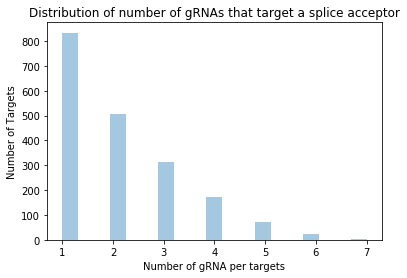

In [4]:
ax = sns.distplot([len(exp_tid_gids_map[tid]) for tid in exp_tid_gids_map], kde=False)
ax.set_title('Distribution of number of gRNAs that target a splice acceptor')
ax.set_ylabel('Number of Targets')
ax.set_xlabel('Number of gRNA per targets')
plt.show()

# Barcode - Sequence Extraction
We have 3 categories of sequence reads (with replicates): GDNA, 'PreCas-Unspliced' or 'PostCas-Unspliced', and 'PreCas-Spliced' or 'PostCas-Spliced'.

## GDNA
Captures the barcode sequence and gRNA sequence from the genomic DNA.

## Pre/PostCas-Unspliced
Captures the Exon B portion of the target sequence and the barcode sequence from the RNA primary transcript.

## Pre/PostCas-Spliced
Captures the sequence between the end of Exon A and the barcode sequence (we can check whether Exon B is present or not in this range).

## What the following code does
The sequence (gRNA sequence in GDNA, the target sequence in Unspliced, the Exon B portion of the target sequence, or lack thereof, in Spliced), the associated barcode sequences, and the sequenc are extracted from the sequencing reads using regular expression pattern matching with at most 5 substitutions permitted (see code comments). The results are written to disk for subsequent processing.

In [5]:
def read_pairs_iterator(suffix):
    read1_fn = os.path.join(READS_DIR, READ_FN_PREFIX + suffix + '_1_sequence.fastq')
    read2_fn = os.path.join(READS_DIR, READ_FN_PREFIX + suffix + '_2_sequence.fastq')
    with open(read1_fn, 'r') as read1_handle:
        with open(read2_fn, 'r') as read2_handle:
            read1_records = SeqIO.parse(read1_handle, "fastq-sanger")
            read2_records = SeqIO.parse(read2_handle, "fastq-sanger")
            while 1:
                try:
                    read1 = next(read1_records)
                    read2 = next(read2_records)
                    yield (read1, read2)
                except StopIteration as e:
                        break

                        
def get_line_count(fn):
        with open(fn) as f:
            return sum(1 for line in f)
        

def get_total_read_pairs(suffix):
    read1_fn = os.path.join(READS_DIR, READ_FN_PREFIX + suffix + '_1_sequence.fastq')
    read2_fn = os.path.join(READS_DIR, READ_FN_PREFIX + suffix + '_2_sequence.fastq')
    return int(min(get_line_count(read1_fn), get_line_count(read2_fn)) / 4)

## Barcode - gRNA Seq Extraction

In [6]:
def identify_bc_grna(gdna_suffix, output_fn):
    # If already cached, do nothing
    if os.path.exists(output_fn):
        return
    
    total_pairs = get_total_read_pairs(gdna_suffix)
    
    # Read 1 pattern match (gRNA) [fuzzy match allowing MAX_GDNA_R1_SUBSTITUTIONS substitutions]:
    # GACGAAACACCG(gRNA seq: N*20 or N*19)GTTTAAGAGCTA
    r1_pattern_prefix = 'GACGAAACACCG'
    r1_pattern_suffix = 'GTTTAAGAGCTA'
    r1_regex = r1_pattern_prefix + '.{19,20}' + r1_pattern_suffix
    r1_fuzzy = '{s<=' + str(MAX_GDNA_R1_SUBSTITUTIONS) + '}'
    r1_prog = regex.compile('('+r1_regex+')' + r1_fuzzy)
    
    # Read 2 pattern match (BC) [fuzzy match allowing MAX_GDNA_R2_SUBSTITUTIONS substitutions]:
    # GTGCAGCTCGCC(rev comp BC seq: N*15)GACCACTACCAG
    r2_pattern_prefix = 'GTGCAGCTCGCC'
    r2_pattern_suffix = 'GACCACTACCAG'
    r2_regex = r2_pattern_prefix + '.{15}' + r2_pattern_suffix
    r2_fuzzy = '{s<=' + str(MAX_GDNA_R2_SUBSTITUTIONS) + '}'
    r2_prog = regex.compile('('+r2_regex+')' + r2_fuzzy)
    
    total_accepted = 0
    fuzzy_matches = 0
    with open(output_fn, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        for r1, r2 in tqdm(read_pairs_iterator(gdna_suffix), total=total_pairs):
            r1_seq = str(r1.seq).upper()
            r2_seq = str(r2.seq).upper()

            # Pattern match
            m1 = r1_prog.search(r1_seq)
            m2 = r2_prog.search(r2_seq)
            if m1 is None or m2 is None:
                continue
            if m1.fuzzy_counts[0] > 0 or m2.fuzzy_counts[0] > 0:
                fuzzy_matches += 1

            g_start, g_end = m1.start() + len(r1_pattern_prefix), m1.end() - len(r1_pattern_suffix)
            bc_start, bc_end = m2.start() + len(r2_pattern_prefix), m2.end() - len(r2_pattern_suffix)

            g_quality = quality_scores_to_string(r1.letter_annotations["phred_quality"][g_start:g_end])
            bc_quality = quality_scores_to_string(r2.letter_annotations["phred_quality"][bc_start:bc_end])
                
            g_seq = r1_seq[g_start:g_end]
            bc_seq = reverse_complement(r2_seq[bc_start:bc_end])
            csvwriter.writerow([bc_seq, bc_quality, g_seq, g_quality])
            total_accepted += 1

    stats = {
        'exact_accepted': total_accepted - fuzzy_matches,
        'fuzzy_accepted': fuzzy_matches,
        'total_accepted': total_accepted,
        'total': total_pairs
    }

    print("Exact Matches:", stats['exact_accepted'], 
          "out of", stats['total'], 
          '({:0.2f}%)'.format(stats['exact_accepted'] * 100 / stats['total']))
    print("Fuzzy Matches:", stats['fuzzy_accepted'], 
          "out of", stats['total'], 
          '({:0.2f}%)'.format(stats['fuzzy_accepted'] * 100 / stats['total']))
    print("Total Accepted:", stats['total_accepted'], 
          "out of", stats['total'], 
          '({:0.2f}%)'.format(stats['total_accepted'] * 100 / stats['total']))
    
    return stats

In [7]:
identify_bc_grna(PRECAS_GDNA_SUFFIX, PRECAS_GDNA_BC_SEQ)
# Stats:
# Exact Matches: 4804805 out of 6469306 (74.27%)
# Fuzzy Matches: 908110 out of 6469306 (14.04%)
# Total Accepted: 5712915 out of 6469306 (88.31%)

identify_bc_grna(POSTCAS_GDNA1_SUFFIX, POSTCAS_GDNA1_BC_SEQ)
# Stats:
# Exact Matches: 3846121 out of 5432654 (70.80%)
# Fuzzy Matches: 1029915 out of 5432654 (18.96%)
# Total Accepted: 4876036 out of 5432654 (89.75%)

identify_bc_grna(POSTCAS_GDNA2_SUFFIX, POSTCAS_GDNA2_BC_SEQ)
# Stats:
# Exact Matches: 2560503 out of 3332188 (76.84%)
# Fuzzy Matches: 472406 out of 3332188 (14.18%)
# Total Accepted: 3032909 out of 3332188 (91.02%)

## Barcode - PreCas Unspliced Target Seq Extraction

In [8]:
def identify_bc_unspliced_target(unspliced_suffix, output_fn, len_limit=None):
    # If already cached, do nothing
    if os.path.exists(output_fn):
        return
    
    total_pairs = get_total_read_pairs(unspliced_suffix)
    
    # Read 1 pattern match (target) [fuzzy match allowing MAX_UNSPLICED_R1_SUBSTITUTIONS substitutions]:
    # GCCCTCGTCGAC(target seq: N*61)
    # Most reads are too short to have anything beyond the 61bp target seq
    r1_pattern_prefix = 'GCCCTCGTCGAC'
    r1_regex = r1_pattern_prefix
    r1_fuzzy = '{s<=' + str(MAX_UNSPLICED_R1_SUBSTITUTIONS) + '}'
    r1_prog = regex.compile('('+r1_regex+')' + r1_fuzzy)
    
    # Read 2 pattern match (BC) [fuzzy match allowing MAX_UNSPLICED_R2_SUBSTITUTIONS substitutions]:
    # CTGGTAGTGGTC(BC seq: N*15)GGCGAGCTGCAC
    r2_pattern_prefix = 'CTGGTAGTGGTC'
    r2_pattern_suffix = 'GGCGAGCTGCAC'
    r2_regex = r2_pattern_prefix + '.{15}' + r2_pattern_suffix
    r2_fuzzy = '{s<=' + str(MAX_UNSPLICED_R2_SUBSTITUTIONS) + '}'
    r2_prog = regex.compile('('+r2_regex+')' + r2_fuzzy)
    
    len_limit = len_limit if len_limit is not None else 1000
    
    total_accepted = 0
    fuzzy_matches = 0
    with open(output_fn, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        for r1, r2 in tqdm(read_pairs_iterator(unspliced_suffix), total=total_pairs):
            r1_seq = str(r1.seq).upper()
            r2_seq = str(r2.seq).upper()
            
            # Pattern match
            m1 = r1_prog.search(r1_seq)
            m2 = r2_prog.search(r2_seq)
            if m1 is None or m2 is None:
                continue
            if m1.fuzzy_counts[0] > 0 or m2.fuzzy_counts[0] > 0:
                fuzzy_matches += 1
                
            t_start = m1.start() + len(r1_pattern_prefix)
            t_end = t_start + len_limit
            bc_start, bc_end = m2.start() + len(r2_pattern_prefix), m2.end() - len(r2_pattern_suffix)

            t_quality = quality_scores_to_string(r1.letter_annotations["phred_quality"][t_start:t_end])
            bc_quality = quality_scores_to_string(r2.letter_annotations["phred_quality"][bc_start:bc_end])
            
            t_seq = r1_seq[t_start:t_end]
            bc_seq = r2_seq[bc_start:bc_end]
            csvwriter.writerow([bc_seq, bc_quality, t_seq, t_quality])
            total_accepted += 1
            
    stats = {
        'exact_accepted': total_accepted - fuzzy_matches,
        'fuzzy_accepted': fuzzy_matches,
        'total_accepted': total_accepted,
        'total': total_pairs
    }

    print("Exact Matches:", stats['exact_accepted'], 
          "out of", stats['total'], 
          '({:0.2f}%)'.format(stats['exact_accepted'] * 100 / stats['total']))
    print("Fuzzy Matches:", stats['fuzzy_accepted'], 
          "out of", stats['total'], 
          '({:0.2f}%)'.format(stats['fuzzy_accepted'] * 100 / stats['total']))
    print("Total Accepted:", stats['total_accepted'], 
          "out of", stats['total'], 
          '({:0.2f}%)'.format(stats['total_accepted'] * 100 / stats['total']))
    
    return stats

In [9]:
precas_unspliced_stats = identify_bc_unspliced_target(PRECAS_UNSPLICED_SUFFIX, PRECAS_UNSPLICED_BC_SEQ, 61)
# Stats:
# Exact Matches: 13994894 out of 17793229 (78.65%)
# Fuzzy Matches: 1007851 out of 17793229 (5.66%)
# Total Accepted: 15002745 out of 17793229 (84.32%)

## Barcode - PostCas Unspliced Target Seq Extraction

In [10]:
identify_bc_unspliced_target(POSTCAS_UNSPLICED1_SUFFIX, POSTCAS_UNSPLICED1_BC_SEQ)
# Stats:
# Exact Matches: 19867537 out of 24052905 (82.60%)
# Fuzzy Matches: 1424870 out of 24052905 (5.92%)
# Total Accepted: 21292407 out of 24052905 (88.52%)

identify_bc_unspliced_target(POSTCAS_UNSPLICED2_SUFFIX, POSTCAS_UNSPLICED2_BC_SEQ)
# Stats:
# Exact Matches: 21579179 out of 25490883 (84.65%)
# Fuzzy Matches: 1566151 out of 25490883 (6.14%)
# Total Accepted: 23145330 out of 25490883 (90.80%)

## Barcode - PreCas Spliced Target Seq Extraction

In [11]:
def determine_spliced_BC(r2m, r1m):
    r2, r2_seq, m2, r2_pattern_prefix, r2_pattern_suffix = r2m
    r1, r1_seq, m1, r1_pattern_prefix, r1_pattern_suffix = r1m
    
    if m1:
        bc1_start, bc1_end = m1.start() + len(r1_pattern_prefix), m1.end() - len(r1_pattern_suffix)
        bc1_quality = r1.letter_annotations["phred_quality"][bc1_start:bc1_end][::-1] # reverse!
        bc1_seq = reverse_complement(r1_seq[bc1_start:bc1_end])
    if m2:
        bc2_start, bc2_end = m2.start() + len(r2_pattern_prefix), m2.end() - len(r2_pattern_suffix)
        bc2_quality = r2.letter_annotations["phred_quality"][bc2_start:bc2_end]
        bc2_seq = r2_seq[bc2_start:bc2_end]
        
    if m1 and not m2:
        return bc1_seq, bc1_quality
    if m2 and not m1:
        return bc2_seq, bc2_quality
    if m1 and m2:
        if bc1_seq == bc2_seq:
            return bc1_seq, bc1_quality if sum(bc1_quality) > sum(bc2_quality) else bc2_quality

        
        # Only consider pairs with at most 3 mismatches
        if hamming_distance(bc1_seq, bc2_seq) <= 3:
            merged_bc_seq = []
            merged_bc_quality = []
            for i in range(len(bc1_seq)):
                if bc1_seq[i] == bc2_seq[i]:
                    merged_bc_seq.append(bc1_seq[i])
                    merged_bc_quality.append(max(bc1_quality[i], bc2_quality[i]))
                else:
                    if bc1_quality[i] > bc2_quality[i]:
                        merged_bc_seq.append(bc1_seq[i])
                        merged_bc_quality.append(bc1_quality[i])
                    elif bc2_quality[i] > bc1_quality[i]:
                        merged_bc_seq.append(bc2_seq[i])
                        merged_bc_quality.append(bc2_quality[i])
                    else:
                        # tie break by seeing which bc sequence has overall higher quality
                        overall_bc1_quality, overall_bc2_quality = sum(bc1_quality), sum(bc2_quality)
                        if overall_bc1_quality > overall_bc2_quality:
                            merged_bc_seq.append(bc1_seq[i])
                            merged_bc_quality.append(bc1_quality[i])
                        elif overall_bc1_quality > overall_bc2_quality:
                            merged_bc_seq.append(bc2_seq[i])
                            merged_bc_quality.append(bc2_quality[i])
                        else:
                            # give up
                            return None, None

            assert(len(merged_bc_seq) == 15)
            bc_seq = ''.join(merged_bc_seq)
            return bc_seq, merged_bc_quality
    return None, None
    

def identify_bc_spliced(spliced_suffix, output_fn):
    # If already cached, do nothing
    if os.path.exists(output_fn):
        return
    
    total_pairs = get_total_read_pairs(spliced_suffix)    
    
    # Read 1 pattern match
    # If exon B NOT skipped, match only target seq post AG, due to splicing:
    # CACAACATCGAG(target seq post acceptor splice site (which should be AG))TGATTACACATA
    #
    # If exon B skipped, match exon C seq:
    # CACAACATCGAG|GACGGCAGCGTGCAG
    # As well as get the BC, and make sure it's the same as the BC in read2 by matching
    # GTGCAGCTCGCC(rev comp BC seq: N*15)GACCACTACCAG
    r1_pattern_prefix = 'CACAACATCGAG'
    r1_pattern_suffix = 'TGATTACACATA'
    r1_regex = r1_pattern_prefix + '.+' + r1_pattern_suffix
    r1_fuzzy = '{s<=' + str(MAX_SPLICED_R1_SUBSTITUTIONS) + '}'
    r1_prog = regex.compile('('+r1_regex+')' + r1_fuzzy)
    
    r1_SKIPPED_regex = 'CACAACATCGAGGACGGCAGCGTGCAG'
    r1_SKIPPED_fuzzy = '{s<=' + str(MAX_SPLICED_SKP_R1_SUBSTITUTIONS) + '}'
    r1_SKIPPED_prog = regex.compile('('+r1_SKIPPED_regex+')' + r1_SKIPPED_fuzzy)
    
    r1_SKIPPED_BC_pattern_prefix = 'GTGCAGCTCGCC'
    r1_SKIPPED_BC_pattern_suffix = 'GACCACTACCAG'
    r1_SKIPPED_BC_regex = r1_SKIPPED_BC_pattern_prefix + '.{15}' + r1_SKIPPED_BC_pattern_suffix
    r1_SKIPPED_BC_fuzzy = '{s<=' + str(MAX_SPLICED_BC_R1_SUBSTITUTIONS) + '}'
    r1_SKIPPED_BC_prog = regex.compile('('+r1_SKIPPED_BC_regex+')' + r1_SKIPPED_BC_fuzzy)
    
    # Read 2 pattern match (BC):
    # CTGGTAGTGGTC(BC seq: N*15)GGCGAGCTGCAC
    r2_pattern_prefix = 'CTGGTAGTGGTC'
    r2_pattern_suffix = 'GGCGAGCTGCAC'
    r2_regex = r2_pattern_prefix + '.{15}' + r2_pattern_suffix
    r2_fuzzy = '{s<=' + str(MAX_SPLICED_R2_SUBSTITUTIONS) + '}'
    r2_prog = regex.compile('('+r2_regex+')' + r2_fuzzy)
    
    total_accepted = 0
    fuzzy_matches = 0
    with open(output_fn, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        for r1, r2 in tqdm(read_pairs_iterator(spliced_suffix), total=total_pairs):
            r1_seq = str(r1.seq).upper()
            r2_seq = str(r2.seq).upper()

            m1 = r1_prog.search(r1_seq)
            m1_skipped = r1_SKIPPED_prog.search(r1_seq)
            m1_skipped_rc_BC = r1_SKIPPED_BC_prog.search(r1_seq)

            m2 = r2_prog.search(r2_seq)

            is_not_skipped = m1 and m1_skipped is None and m1_skipped_rc_BC is None
            is_skipped = m1 is None and m1_skipped and m1_skipped_rc_BC

            # Can't do much with these, probably sequencing errors preventing exact prefix/suffix matches
            # among other reasons. Ignore these for now.
            if not (is_not_skipped or is_skipped):
                continue
            # Can't be both at the same time...
            if (is_not_skipped and is_skipped):
                continue
            
            bc_seq, bc_quality = determine_spliced_BC((r2, r2_seq, m2, r2_pattern_prefix, r2_pattern_suffix),
                                          (r1, r1_seq, m1_skipped_rc_BC, 
                                           r1_SKIPPED_BC_pattern_prefix, r1_SKIPPED_BC_pattern_suffix))
            # BC must be decipherable
            if not bc_seq:
                continue
                
            if ((is_not_skipped and m1.fuzzy_counts[0] > 0) or 
                (is_skipped and (m1_skipped.fuzzy_counts[0] > 0 or m1_skipped_rc_BC.fuzzy_counts[0] > 0)) or 
                (m2 and m2.fuzzy_counts[0] > 0)):
                fuzzy_matches += 1

            if is_not_skipped:
                t_start, t_end = m1.start() + len(r1_pattern_prefix), m1.end() - len(r1_pattern_suffix)
                t_quality = quality_scores_to_string(r1.letter_annotations["phred_quality"][t_start:t_end])
    
                t_seq = r1_seq[t_start:t_end]
                total_accepted += 1
                csvwriter.writerow([bc_seq, quality_scores_to_string(bc_quality), t_seq, t_quality])
            elif is_skipped:
                total_accepted += 1
                csvwriter.writerow([bc_seq, quality_scores_to_string(bc_quality), 'SKIPPED'])

    stats = {
        'exact_accepted': total_accepted - fuzzy_matches,
        'fuzzy_accepted': fuzzy_matches,
        'total_accepted': total_accepted,
        'total': total_pairs
    }

    print("Exact Matches:", stats['exact_accepted'], 
          "out of", stats['total'], 
          '({:0.2f}%)'.format(stats['exact_accepted'] * 100 / stats['total']))
    print("Fuzzy Matches:", stats['fuzzy_accepted'], 
          "out of", stats['total'], 
          '({:0.2f}%)'.format(stats['fuzzy_accepted'] * 100 / stats['total']))
    print("Total Accepted:", stats['total_accepted'], 
          "out of", stats['total'], 
          '({:0.2f}%)'.format(stats['total_accepted'] * 100 / stats['total']))
    
    return stats

In [12]:
identify_bc_spliced(PRECAS_SPLICED_SUFFIX, PRECAS_SPLICED_BC_SEQ)
# Stats:
# Exact Matches: 3337696 out of 5902730 (56.54%)
# Fuzzy Matches: 881806 out of 5902730 (14.94%)
# Total Accepted: 4219502 out of 5902730 (71.48%)

## Barcode - PostCas Spliced Target Seq Extraction

In [13]:
identify_bc_spliced(POSTCAS_SPLICED1_SUFFIX, POSTCAS_SPLICED1_BC_SEQ)
# Stats:
# Exact Matches: 4367086 out of 8380139 (52.11%)
# Fuzzy Matches: 1108841 out of 8380139 (13.23%)
# Total Accepted: 5475927 out of 8380139 (65.34%)

identify_bc_spliced(POSTCAS_SPLICED2_SUFFIX, POSTCAS_SPLICED2_BC_SEQ)
# Stats:
# Exact Matches: 6370370 out of 9572842 (66.55%)
# Fuzzy Matches: 1665108 out of 9572842 (17.39%)
# Total Accepted: 8035478 out of 9572842 (83.94%)